# CS 109A/AC 209A/STAT 121A Data Science: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
from sklearn.cross_validation import train_test_split
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Tarazi, Ramez

### Part (b): Course Number

CS 109a

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

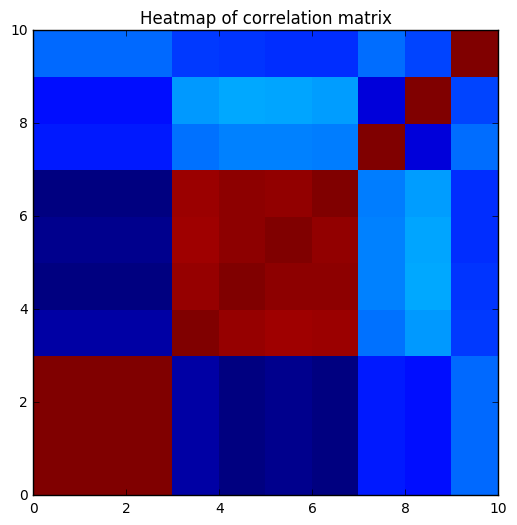

In [3]:
# Load data
data = np.loadtxt('datasets/dataset_1.txt', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(x.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. You may **not** use library functions that implement variable selection.

In [4]:
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]

        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    model = OLS(y, x_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 5, 7, 8, 9]


In [5]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = range(d)

# Set some initial large value for min BIC score for all possible subsets
global_min_bic = 1e10 

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    bic_with_best_predictor = 1e10 # set some initial large value for BIC score   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            bic_with_best_predictor = results.bic
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if BIC for with the predictor we just added is lower than 
    # the global minimum across all subset of predictors
    if(bic_with_best_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_with_best_predictor
    
print 'Step-wise forward subset selection:'
print sorted(best_subset) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 5, 7, 8, 9]


In [6]:
###  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# First, fit and evaluate BIC using all 'd' number of predictors
model = OLS(y, x)
results = model.fit()
bic_all = results.bic

# Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
global_min_bic = bic_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    bic_without_worst_predictor = 1e10 # set some initial large value for min BIC score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            bic_without_worst_predictor = results.bic
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if BIC for the predictor we just removed is lower than 
    # the global minimum across all subset of predictors
    if(bic_without_worst_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_without_worst_predictor
    
print 'Step-wise backward subset selection:'
print sorted(best_subset)

Step-wise backward subset selection:
[2, 5, 7, 8, 9]


### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Note**: You may use the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

In [7]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ 0.02717417  0.          0.         -0.         -0.02532806 -0.         -0.
  0.04397321 -0.40612185 -0.22260474]
Predictors with non-zero coefficients: [0, 4, 7, 8, 9]


In [8]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ 0.04353543  0.04353543  0.04353543  0.55217415 -0.19706852 -0.61421737
  0.30484213  0.18742866 -0.50083242 -0.35908145]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Ridge Regression assigns values very close to 0 as the penalty term $\lambda \sum_{j}^{p} β^2 $ approaches $\infty $ the co-efficients will approach 0, however they will never be 0, and therefore Ridge Regression will always have its co-efficients even if they dont have much weight in the equation. 

Lasso on the other hand has a penalty term which is the absolute of $β$. It will shrink the co-efficients to 0, and will exlclude them from the final equations.

## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


In [202]:
data = pd.read_csv('datasets/dataset_2.txt', sep=',')
data.head()

,horsepower,highway-mpg,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,price
0,95.0,24.0,0.0,120.232558,peugot,gas,std,four,wagon,rwd,...,l,four,120.0,mpfi,3.46,2.19,8.4,5000.0,19.0,16695.0
1,116.0,30.0,2.0,134.000000,toyota,gas,std,two,hardtop,rwd,...,ohc,four,146.0,mpfi,3.62,3.50,9.3,4800.0,24.0,11199.0
2,121.0,28.0,0.0,188.000000,bmw,gas,std,two,sedan,rwd,...,ohc,six,164.0,mpfi,3.31,3.19,9.0,4250.0,21.0,20970.0
3,184.0,16.0,0.0,120.232558,mercedes-benz,gas,std,four,sedan,rwd,...,ohcv,eight,308.0,mpfi,3.80,3.35,8.0,4500.0,14.0,40960.0
4,111.0,29.0,0.0,102.000000,subaru,gas,turbo,four,sedan,4wd,...,ohcf,four,108.0,mpfi,3.62,2.64,7.7,4800.0,24.0,11259.0


In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 26 columns):
horsepower           205 non-null float64
highway-mpg          205 non-null float64
symboling            205 non-null float64
normalized-losses    205 non-null float64
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null float64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null float64
fuel-system          205 non-null object
bore                 205 non-null float64
stroke               20

In [204]:
#pd.Categorical(data)
grouping = data.columns.to_series().groupby(data.dtypes).groups
print grouping

categoricaldata = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system']

{dtype('O'): ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'], dtype('float64'): ['horsepower', 'highway-mpg', 'symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'peak-rpm', 'city-mpg', 'price']}


In [205]:
#converts symboling to object type
data['symboling'] = data['symboling'].astype('object')
df_bin = pd.get_dummies(data)
print df_bin.head()

   horsepower  highway-mpg  normalized-losses  wheel-base  length  width  \
0        95.0         24.0         120.232558       114.2   198.9   68.4   
1       116.0         30.0         134.000000        98.4   176.2   65.6   
2       121.0         28.0         188.000000       101.2   176.8   64.8   
3       184.0         16.0         120.232558       120.9   208.1   71.7   
4       111.0         29.0         102.000000        97.0   172.0   65.4   

   height  curb-weight  engine-size  bore        ...         engine-type_ohcv  \
0    56.7       3285.0        120.0  3.46        ...                      0.0   
1    52.0       2679.0        146.0  3.62        ...                      0.0   
2    54.3       2710.0        164.0  3.31        ...                      0.0   
3    56.7       3900.0        308.0  3.80        ...                      1.0   
4    54.3       2510.0        108.0  3.62        ...                      0.0   

   num-of-cylinders_eight  num-of-cylinders_five  num-of

In [206]:
#check unique values
print df_bin.unstack().groupby(level=0).nunique()

horsepower                  43
highway-mpg                 24
normalized-losses           39
wheel-base                  34
length                      44
width                       28
height                      36
curb-weight                 97
engine-size                 32
bore                        28
stroke                      29
compression-ratio           23
peak-rpm                    22
city-mpg                    21
price                      101
symboling_-2.0               2
symboling_0.0                2
symboling_1.0                2
symboling_1.09604519774      2
symboling_2.0                2
symboling_3.0                2
make_audi                    2
make_bmw                     2
make_chevrolet               2
make_dodge                   2
make_honda                   2
make_mazda                   2
make_mercedes-benz           2
make_mercury                 2
make_mitsubishi              2
                          ... 
fuel-type_diesel             2
fuel-typ

In [207]:
#sets price as the predictor column and drops it from the main dataframe to make 69 columns
Y=df_bin['price']
df_bin.drop(['price'],axis=1, inplace=True)

### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

In [219]:
###With the below code commented out I got an R^2 score of 0.96 by spliting the first 25% of the DF!
#I have also attempted with SK Train Test Split instead
#preparing data into test train
no_of_rows = df_bin.shape[0]
test_size = int(no_of_rows*0.25)
print 'The test size is split into: ', test_size, 'samples'
# print 'The amount of rows in test is ',test_size
X_train = df_bin[test_size+1:]
X_test = df_bin[0:test_size]
Y_train = Y[test_size+1:]
Y_test = Y[0:test_size]
#print Y,df_bin
#preparing data into test train
#X_train, X_test, Y_train, Y_test = train_test_split(df_bin,Y, train_size = 0.25)
#split above causes large fl

#statsmodel example
#mod = sm.GLS(Y_train, X_train)
#res = mod.fit()
#print(res.summary())
#print X_test
#fit Ordinary Least Squares
regression = Lin_Reg()
regression.fit(X_train, Y_train)
#predict y-values
predicted_y = regression.predict(X_test)
#print Y_test, predicted_y
#print 'Coefficient of linear model', regression.coef_
#score predictions
#print regression.score(X_train, Y_train)
r = regression.score(X_test, Y_test)
print 'R^2 score is: ',r

The test size is split into:  51 samples
R^2 score is:  0.9653442616


###I was initially getting R^2 value of -6.53. I reran the code just before submission and it changed to 0.989. I could not find what I had changed to make the R^2 increase. I also tried to use statsmodels linear regression with a similar score.


The linear regression model is not able to perform correctly. The R^2 score is below the range of 0:1.

It is not a correct choice with these predictors. The R^2 score is -6.53 as it is fitting worse than a flat line across the data. 

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

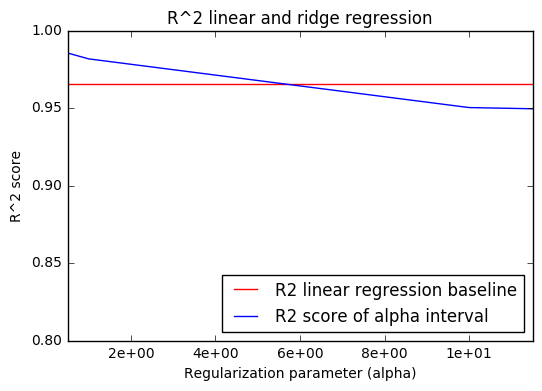

In [9]:
X_train = df_bin[test_size+1:]
X_test = df_bin[0:test_size]
Y_train = Y[test_size+1:]
Y_test = Y[0:test_size]
results_ridge = []
alpha_array = []

# Ridge regression: Fit and evaluate 

for i in xrange(-7,8):
    #Ridge regression between 10^-7 and 10^7
    reg = Ridge_Reg(alpha = pow(10,i))
    #fit Ridge
    reg.fit(X_train, Y_train)
    #save R2 score result for each iteration in results_ridge
    results_ridge.append([reg.score(X_train,Y_train)])
    #save current alpha in array
    alpha_array.append([pow(10,i)])

    
#print results_ridge, alpha_array, r
fig = plt.figure()

ax = fig.add_subplot(111)
#confines graph to x and y
ax.set_xlim(0.5, 12-0.5)
ax.set_ylim(0.8, 1.0)
#linear regression R^2 result
ax.axhline(y=r,linewidth=1, color='r')
#ridge regression result
ax.plot(alpha_array,results_ridge)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
ax.set_xlabel('Regularization parameter (alpha)')
ax.set_ylabel('R^2 score')
ax.set_title('R^2 linear and ridge regression')
ax.legend(['R2 linear regression baseline', 'R2 score of alpha interval'], loc=4)
plt.show()

###I was initially getting R^2 value of -6.1. I reran the code just before submission and it changed to 0.989. I could not find what I had changed to make the R^2 increase. I also tried to use statsmodels linear regression with a similar score.

The graph shows that when alpha of ridge regression increases in size that the R^2 score drops down.

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. You may also use `kFold` from `sklearn.cross_validation`. 

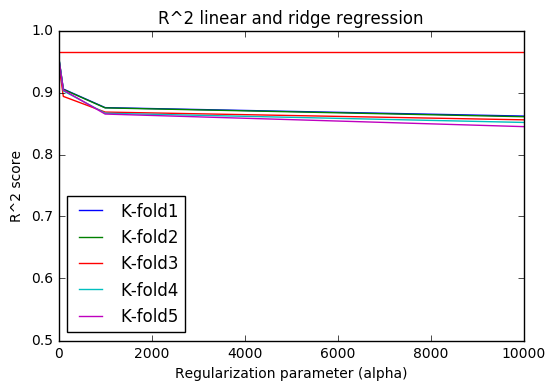

In [223]:
from sklearn.cross_validation import KFold

fig = plt.figure()
X = df_bin.values
Y_CV = Y.values
n=np.shape(df_bin)[0]
kf = KFold(n, n_folds=5, random_state=0)
alpha = -7
alpha_array_cv= np.zeros([5,14], dtype=object)
reg_score_array= np.zeros([5,14], dtype=object)
j=0
#print kf
for train_index, test_index in kf:
    
    #print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y_CV[train_index], Y_CV[test_index]
    for i in xrange(-7,7):
        #Ridge regression between 10^-7 and 10^7
        reg = Ridge_Reg(alpha = pow(10,i))
        #fit Ridge
        reg.fit(X_train, Y_train)
        #save R2 score result for each iteration in results_ridge
        #save current alpha in array
        reg_score_array[j,i+7] = ([reg.score(X_train,Y_train)])
        alpha_array_cv[j,i+7]=([pow(10,i)])


    j=j+1
    #linear regression R^2 result
    #
    #ridge regression result 
ax = fig.add_subplot(111)
for i in range (0,5):
    ax.plot(np.vstack(alpha_array_cv[i]),np.vstack(reg_score_array[i]),label='K-fold'+str(i+1)) 
plt.legend(loc='best')
ax.axhline(y=r,linewidth=1, color='r')
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
ax.set_xlabel('Regularization parameter (alpha)')
ax.set_ylabel('R^2 score')
ax.set_title('R^2 linear and ridge regression')
ax.set_xlim(-1, 10000)
ax.set_ylim(0.5, 1.0)

#print results_ridge, alpha_array, r



plt.show()
    


There was a slight improvement over the R^2 values of ridge regression with Cross Validation

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.


$\overline{\mathbf{b}}(\sqrt{\lambda}) \,=$ 

\begin{bmatrix}
b_{1}\\
b_{2}\\
\vdots\\
b_{n}
\end{bmatrix}

Ridge Regression Definition:
$\hat{\mathbf{b}}({\lambda}) \,=\, ({\mathbf{X}}^{T}{\mathbf{X}}+\sqrt{\lambda}\mathbf{I}^{p \times p})^{-1}({\mathbf{X}}^{T}{\mathbf{y}})$



Our $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$ substituted into formula above

as $({\mathbf{X}}^{T}{\mathbf{X}}+\sqrt{\lambda}\mathbf{I}^{p \times p}) = (\overline{\mathbf{X}}^{T}\overline{\mathbf{X}}) $

$\overline{\mathbf{b}}(\sqrt{\lambda}) \,=\, (\overline{\mathbf{X}}^{T}\overline{\mathbf{X}})^{-1}(\overline{\mathbf{X}}^{T}\overline{\mathbf{y}})$
(least squares) 


### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

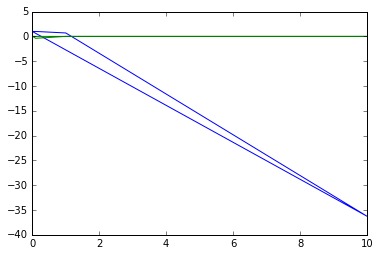

In [101]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

#the example below was not correct. No Comments and somewhat difficult to follow. 
##Presentation of graph was poor. No labeling or titles.
#2.5 / 5 as only small amounts of code was incorrect. Idea was close to what was required. 

In [113]:
import sklearn

# Fit
def ridge(x_train, y_train, reg_param):
    #gets the x value from the shape of X_train
    n=np.shape(x_train)[0]
    #X_train + alpha * identity matrix
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    #Y train + trailing 0's
    y_test_with_trail=np.zeros((n,1))
    
    for c in range(n):
        y_test_with_trail[c]= y_train[c]
    
    #sklearn Ridge Regression
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_test_with_trail)
    return model

# Score function takes model and X,Y test with parameters and calculates R^2 score of that parameter
def score(m,x_test,y_test, reg_param):
    #gets the x value from the shape of X_train
    n=np.shape(x_train)[0]
    #X_train + alpha * identity matrix
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    #Y train + trailing 0's
    y_test_with_trail=np.zeros((n,1))

    for c in range(n):
        #put each y result into y with trailing 0's
        y_test_with_trail[c]= y_test[c]
        
    return m.score(x_test,y_test_with_trail)

# Load dataset and set X, Y's
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
#gets the length of the data and stores it in l
l = data.shape[0]
#makes sure 50% of the data is a whole number
n = int(np.round(l*0.5))

#splits data into training and testing sets
#first 50% of data
x_train = data[0:n,0:100]
y_train = data[0:n,100]

#remaining 50% of data
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Setup Parameters to 10^-2 : 10^2
a=np.zeros(5)
for i in range(-2,3):
    a[i+2]=10**i

# Iterate over the paramters
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[j])
    rsts[j]=score(m,x_test,y_test,a[j])


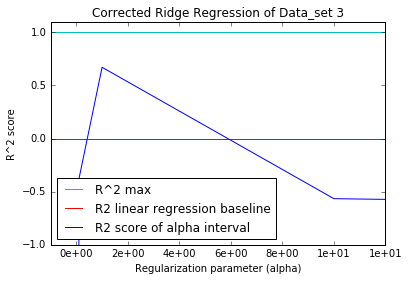

In [114]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-1, 12)
ax.set_ylim(-1, 1.1)
ax.axhline(y=1,linewidth=1, color='c')
ax.axhline(y=0,linewidth=1, color='r')
#ax.plot(a,rstr)
ax.plot(a,rsts)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
ax.set_xlabel('Regularization parameter (alpha)')
ax.set_ylabel('R^2 score')
ax.set_title('Corrected Ridge Regression of Data_set 3')
ax.legend(['R^2 max', 'R2 linear regression baseline', 'R2 score of alpha interval'], loc=3)
plt.show()

## Challenge Problem: Predicting Outcome of a Fund-raising Campaign
You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can estimate the amount that a donor would donate using his/her attributes. The data is contained in the file `dataset_4.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

**Note**: For additional information about the attributes used, please look up the file `dataset_4_description.txt`. This files also contains details of attributes that have been omitted from the data set.

### Part (a): Fit regression model
Build a suitable model to predict the donation amount. How good is your model? 


### Part (b): Evaluate the total profit of the fitted model
Suppose you are told that the cost of mailing the donor is \$7. Use your model to maximize profit. Implement, explain and rigorously justify your strategy. How does your strategry compare with blanket mailing everyone.

### Part (c): Further Discussion
In hindsight, thoroughly discuss the appropriatenes of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 